In [1]:
# 1️⃣ 필수 패키지 설치
!pip install torch torchvision matplotlib pillow opencv-python tqdm

In [2]:
# 2️⃣ GitHub repo 클론 및 이동
!git clone https://github.com/richzhang/colorization.git
%cd colorization

Cloning into 'colorization'...
remote: Enumerating objects: 4873, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4873 (delta 133), reused 121 (delta 121), pack-reused 4707 (from 1)
Receiving objects: 100% (4873/4873), 177.90 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (422/422), done.
/content/colorization


In [4]:
# 3️⃣ 사전 학습 모델 수동 다운로드 (ECCV16 + SIGGRAPH17)
import os

os.makedirs("models", exist_ok=True)

# ECCV16 모델
!wget -O models/colorization_release_v2.caffemodel https://data.csail.mit.edu/places/models/colorization/colorization_release_v2.caffemodel

# SIGGRAPH17 모델
!wget -O models/siggraph17-df00044c.pth https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth

--2025-10-30 03:27:54--  https://data.csail.mit.edu/places/models/colorization/colorization_release_v2.caffemodel
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.131.233
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-10-30 03:27:56 ERROR 404: Not Found.

--2025-10-30 03:27:56--  https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth
Resolving colorizers.s3.us-east-2.amazonaws.com (colorizers.s3.us-east-2.amazonaws.com)... 3.5.131.92, 3.5.129.148, 3.5.131.121, ...
Connecting to colorizers.s3.us-east-2.amazonaws.com (colorizers.s3.us-east-2.amazonaws.com)|3.5.131.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136787426 (130M) [application/x-www-form-urlencoded]
Saving to: ‘models/siggraph17-df00044c.pth’

models/siggraph17-d 100%[===================>] 130.45M  14.0MB/s    in 11s     

2025-10-30 03:28:08 (11.8 MB/s) - ‘models/siggrap

In [6]:
# 4️⃣ 사용자 전용 이미지 폴더 생성 (/content/colorization/my_images)
my_image_dir = '/content/colorization/my_images'
os.makedirs(my_image_dir, exist_ok=True)

In [7]:
# 예시 파일 이름 (사용자가 넣은 파일명에 맞게 바꿔주세요)
img_filename = 'TEST6.JPEG'  # 예: 'photo1.png' 등
img_path = os.path.join(my_image_dir, img_filename)
print(f"🎯 현재 테스트 이미지 경로: {img_path}")


🎯 현재 테스트 이미지 경로: /content/colorization/my_images/TEST6.JPEG


In [8]:
# 5️⃣ 컬러화 실행 코드
import torch
import matplotlib.pyplot as plt
from colorizers import *

# GPU 사용 여부 확인
use_gpu = torch.cuda.is_available()
print("GPU 사용 가능 여부:", use_gpu)

GPU 사용 가능 여부: True


In [9]:
# 모델 로드
colorizer_eccv16 = eccv16(pretrained=True).eval()
colorizer_siggraph17 = siggraph17(pretrained=True).eval()
if use_gpu:
    colorizer_eccv16.cuda()
    colorizer_siggraph17.cuda()

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth


100%|██████████| 123M/123M [00:10<00:00, 12.5MB/s]


Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/siggraph17-df00044c.pth" to /root/.cache/torch/hub/checkpoints/siggraph17-df00044c.pth


100%|██████████| 130M/130M [00:11<00:00, 11.7MB/s]


In [10]:
# 이미지 로드 및 전처리
if not os.path.exists(img_path):
    raise FileNotFoundError(f"❌ 이미지 파일이 존재하지 않습니다: {img_path}")

img = load_img(img_path)
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))
if use_gpu:
    tens_l_rs = tens_l_rs.cuda()

In [11]:
# 컬러화 결과 생성
img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

/content/colorization/colorizers/util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))


In [12]:
# 결과 저장 폴더 생성
os.makedirs('results', exist_ok=True)
eccv16_path = os.path.join('results', f'{img_filename}_eccv16.png')
siggraph17_path = os.path.join('results', f'{img_filename}_siggraph17.png')

plt.imsave(eccv16_path, out_img_eccv16)
plt.imsave(siggraph17_path, out_img_siggraph17)

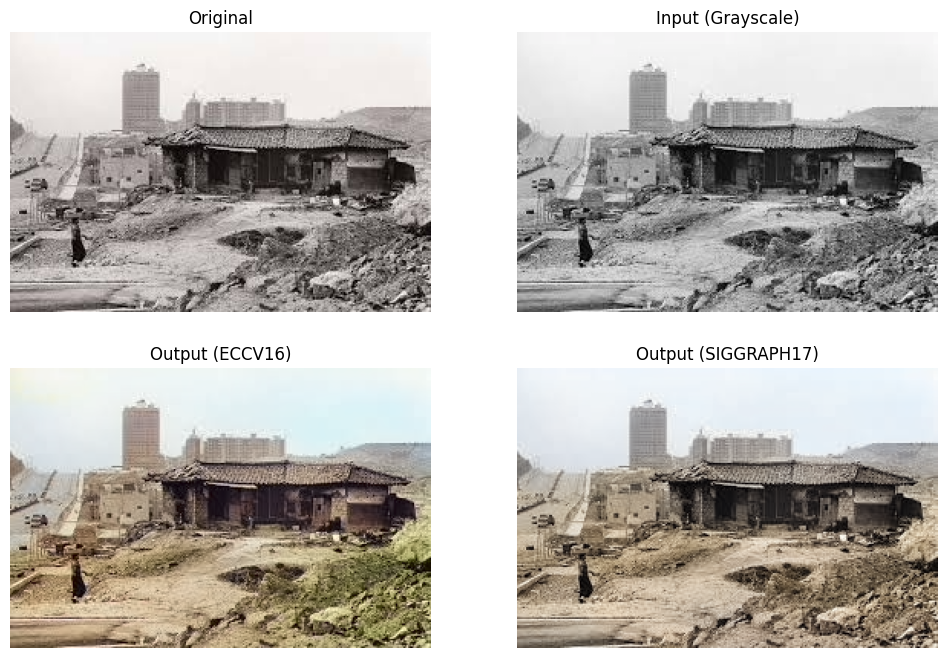


📁 결과 파일 저장 완료:
 - results/TEST6.JPEG_eccv16.png
 - results/TEST6.JPEG_siggraph17.png


In [13]:
# 6️⃣ 결과 시각화
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_bw)
plt.title('Input (Grayscale)')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(out_img_eccv16)
plt.title('Output (ECCV16)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(out_img_siggraph17)
plt.title('Output (SIGGRAPH17)')
plt.axis('off')

plt.show()

print("\n📁 결과 파일 저장 완료:")
print(f" - {eccv16_path}")
print(f" - {siggraph17_path}")